In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# define data directories
train_dir = '/content/drive/MyDrive/ColabNotebooks/cardir/train'
valid_dir = '/content/drive/MyDrive/ColabNotebooks/cardir/valid'
test_dir ='/content/drive/MyDrive/ColabNotebooks/cardir/test'

# define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([
    transforms.Resize(299*299)
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize(331),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_test_transforms)
test_data = datasets.ImageFolder(test_dir, transform=valid_test_transforms)

# Define dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
validloader = DataLoader(valid_data, batch_size=32)
testloader = DataLoader(test_data, batch_size=32)

# load Inceptionv3 model and freeze parameters
model = models.inception_v3(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# replace last layer
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, 196)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)

# move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Define a function for carrying out the validation step
def validation(model, dataloader, criterion):
    valid_loss = 0
    accuracy = 0
    for ii, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        valid_loss += criterion(outputs, labels).item()
        ps = torch.exp(outputs)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy


# train the model
epochs = 30
steps = 0
print_every = 40

for e in range(epochs):

    running_loss = 0
    train_accuracy = 0

    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)

        # zeroing parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes
        outputs, aux_outputs = model.forward(inputs)
        loss = criterion(outputs, labels) + 0.4 * criterion(aux_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        ps = torch.exp(outputs)
        equality = (labels.data == ps.max(dim=1)[1])
        train_accuracy += equality.type(torch.FloatTensor).mean()

        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()

            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validloader, criterion)

            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Training Accuracy: {round(float(train_accuracy/print_every),3)}\
            Valid Loss: {round(valid_loss/len(validloader),3)} \
            Valid Accuracy: {round(float(accuracy/len(validloader)),3)}")

            running_loss = 0

            # Turning training back on
            model.train()


No. epochs: 1,             Training Loss: 7.55             Training Accuracy: 0.004            Valid Loss: 5.281             Valid Accuracy: 0.01
No. epochs: 1,             Training Loss: 7.449             Training Accuracy: 0.02            Valid Loss: 5.225             Valid Accuracy: 0.016
No. epochs: 1,             Training Loss: 7.371             Training Accuracy: 0.03            Valid Loss: 5.122             Valid Accuracy: 0.024
No. epochs: 1,             Training Loss: 7.265             Training Accuracy: 0.055            Valid Loss: 5.033             Valid Accuracy: 0.047
No. epochs: 1,             Training Loss: 7.152             Training Accuracy: 0.081            Valid Loss: 4.975             Valid Accuracy: 0.041
No. epochs: 2,             Training Loss: 2.589             Training Accuracy: 0.012            Valid Loss: 4.888             Valid Accuracy: 0.046
No. epochs: 2,             Training Loss: 6.885             Training Accuracy: 0.034            Valid Loss: 4.817   

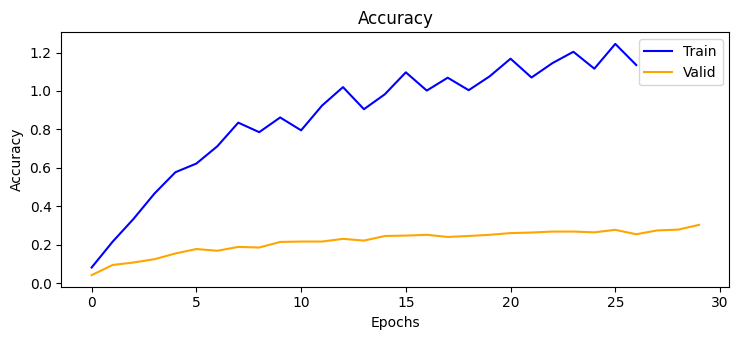

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

Train = np.array([.081, .215, .334, .466, .577, .622, .712, .835, .7855, .862, .795, .924, 1.02, .905, .983, 1.097, 1.002, 1.069, 1.004, 1.076, 1.168, 1.07, 1.145, 1.204, 1.116, 1.245, 1.135])
Valid = np.array([.041, .094, .107, .124, .154, .177, .168, .188, .185, .214, .216, .216, .23, .221, .245, .247, .251, .24, .245, .251, .26, .263, .268, .268, .264, .277, .254, .274, .278, .303 ])

ax1 = plt.subplot()
l1, = ax1.plot(Train, color='Blue')
l2, = ax1.plot(Valid, color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
plt.legend([l1, l2], ["Train", "Valid"])
plt.title("Accuracy")
plt.show()

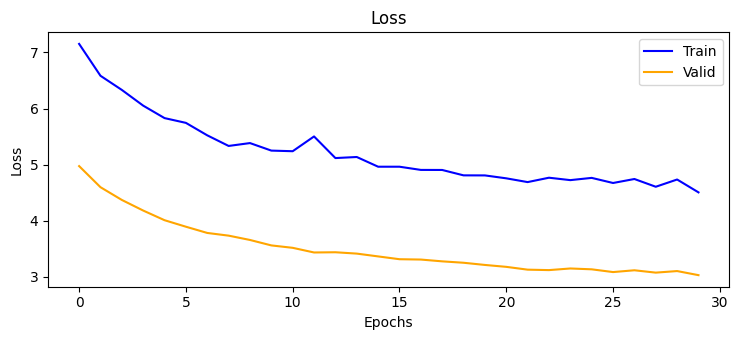

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
Train = np.array([7.152, 6.584, 6.332, 6.052, 5.83, 5.745, 5.523, 5.334, 5.385, 5.251, 5.24, 5.5032, 5.118, 5.137, 4.964, 4.964, 4.907, 4.906, 4.81, 4.809, 4.757, 4.69, 4.768, 4.725, 4.765, 4.674, 4.745, 4.607, 4.736, 4.507,])
Valid = np.array([4.975, 4.599, 4.372, 4.183, 4.011, 3.895, 3.784, 3.736, 3.659, 3.562, 3.519, 3.436, 3.44, 3.416, 3.366, 3.316, 3.31, 3.278, 3.253, 3.214, 3.18, 3.13, 3.122, 3.151, 3.136, 3.087, 3.119, 3.077, 3.105, 3.032 ])

ax1 = plt.subplot()
l1, = ax1.plot(Train, color='Blue')
l2, = ax1.plot(Valid, color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
plt.legend([l1, l2], ["Train", "Valid"])
plt.title("Loss")
plt.show()

In [ ]:
correct = 0
total = 0
model.to('cuda')

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Extract tensor containing probabilities
        probabilities = outputs.logits
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(probabilities, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")


Test accuracy of model: 1.903%


In [ ]:
checkpoint = {'state_dict': model.state_dict(),
              'model': model.fc,
              'class_to_idx': train_data.class_to_idx,
              'opt_state': optimizer.state_dict,
              'num_epochs': epochs}

torch.save(checkpoint, '/content/drive/MyDrive/ColabNotebooks/my_Inceptionv3checkpoint.pth')

In [ ]:
def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)

    #model.load_state_dict(checkpoint['state_dict'])
    model.load_state_dict(checkpoint['state_dict'], strict=False)
    model.class_to_idx = checkpoint['class_to_idx']

    return model

In [ ]:
model = load_checkpoint('/content/drive/MyDrive/ColabNotebooks/my_Inceptionv3checkpoint.pth')
# Checking model i.e. should have 196 output units in the classifier
print(model)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
model = torch.nn.DataParallel(model)

In [ ]:
import PIL.Image as Image
from IPython.display import display

In [ ]:
def process_image(image):

    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}' + '.jpg')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((299,299)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5,0.5,0.5],
                                                         [0.5,0.5,0.5])])

    # Transforming image for use with network
    pil_tfd = transform(pil_im)

    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)

    return array_im_tfd

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

In [ ]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file

    # Loading model
    loaded_model = load_checkpoint(model)
    # Moving the loaded model to the GPU
    loaded_model.cuda()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Moving the input tensor to the GPU
    img_tensor = img_tensor.cuda()
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)
    input=Variable(img_add_dim)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]

    # Converting probabilities and outputs to lists
    conf = np.array(probs_top.cpu())[0]
    predicted = np.array(predicted_top.cpu())[0]

    return conf, predicted



In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(train_dir)

print(classes, c_to_idx)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012

In [ ]:
def plot_solution(cardir, model):

  # Inputs are paths to saved model and test image
  model_path = '/content/drive/MyDrive/ColabNotebooks/my_Inceptionv3checkpoint.pth'
  image_path = test_dir+cardir
  carname = cardir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):

      names += [classes[predicted1[i]]]
  # Creating PIL image
  image = Image.open(image_path+'.jpg')
  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))
  ax[0].imshow(image)
  ax[0].set_title(carname)
  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis()

  plt.show()

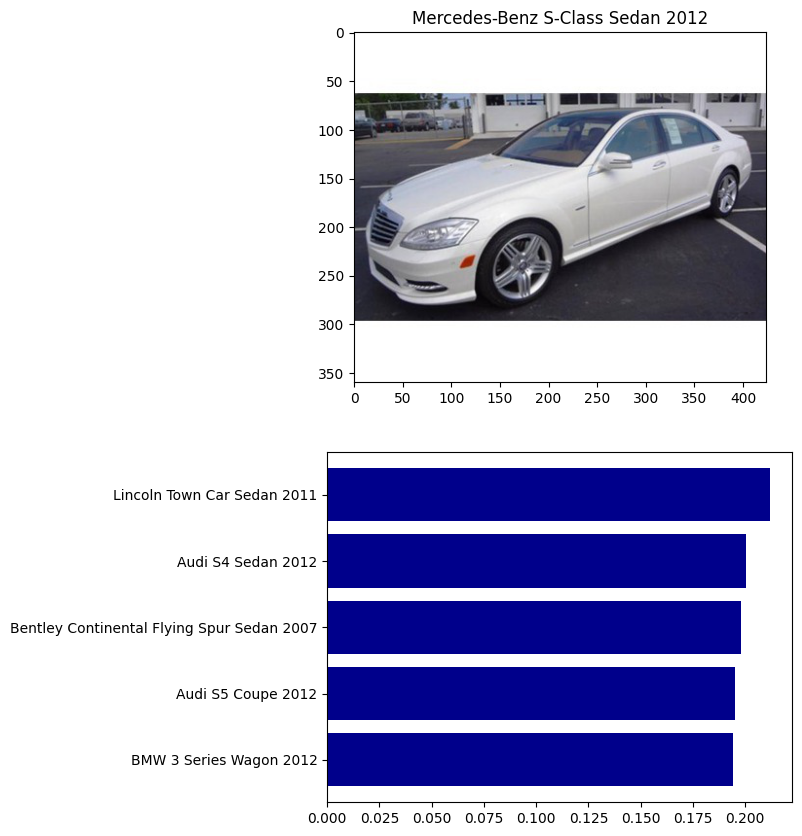

In [ ]:
cardir='/Mercedes-Benz S-Class Sedan 2012/06543'
plot_solution(cardir , model)

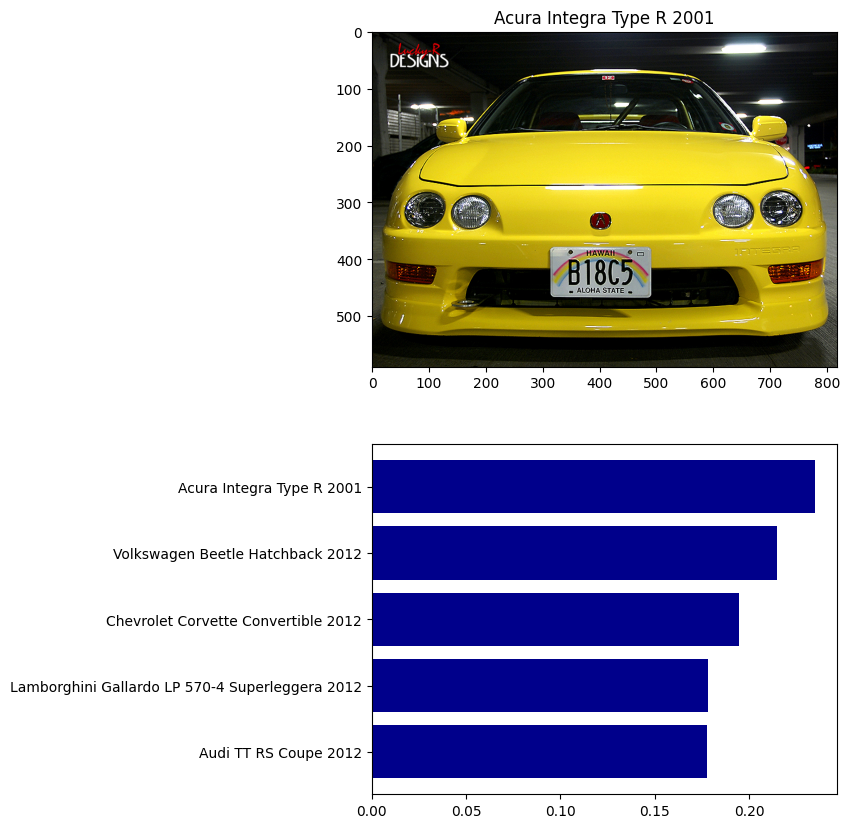

In [ ]:
cardir='/Acura Integra Type R 2001/06181'
plot_solution(cardir , model)

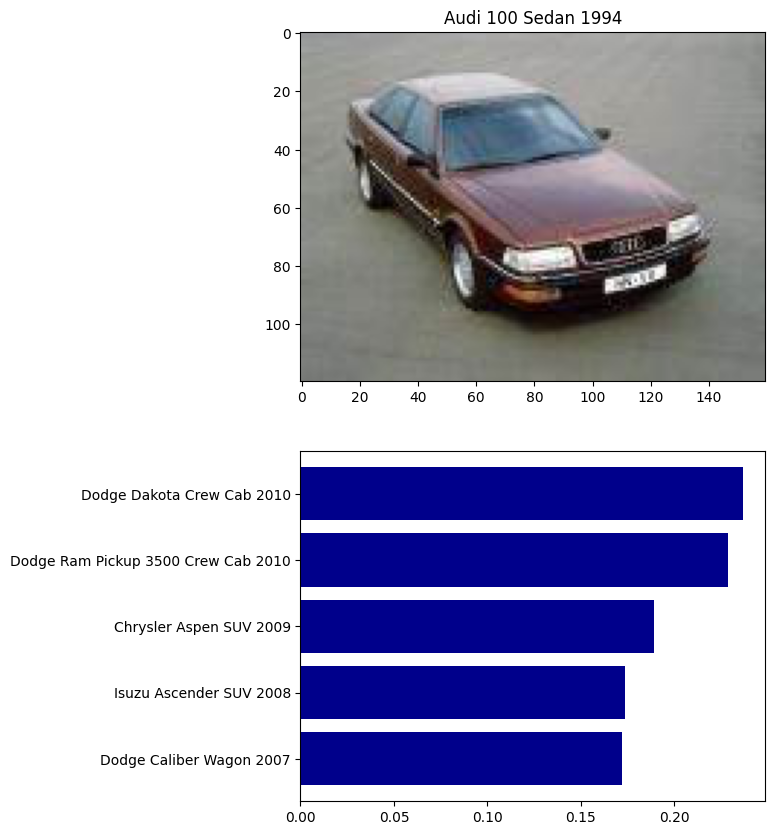

In [ ]:
cardir='/Audi 100 Sedan 1994/00082'
plot_solution(cardir , model)

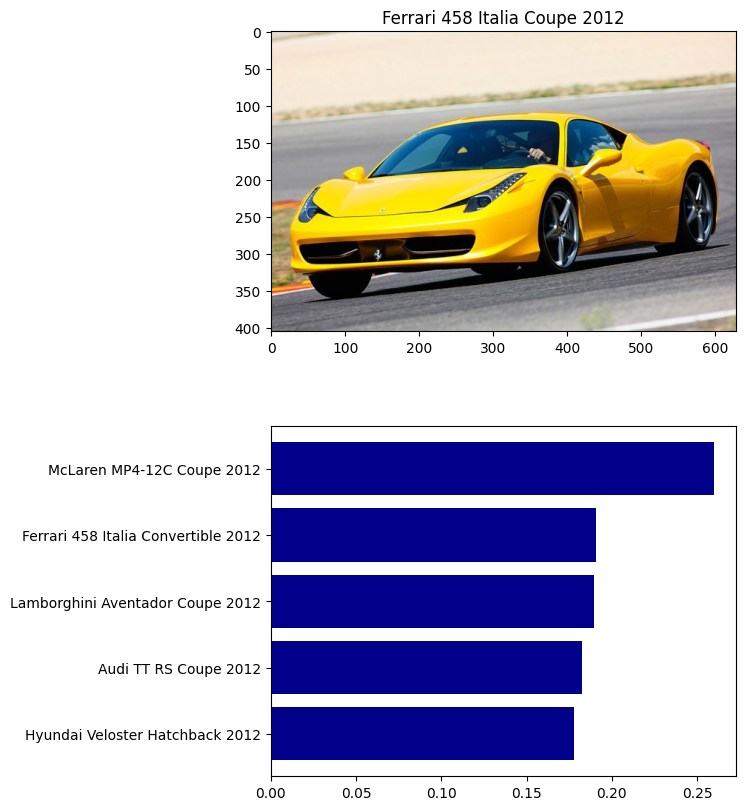

In [ ]:
cardir='/Ferrari 458 Italia Coupe 2012/07358'
plot_solution(cardir , model)

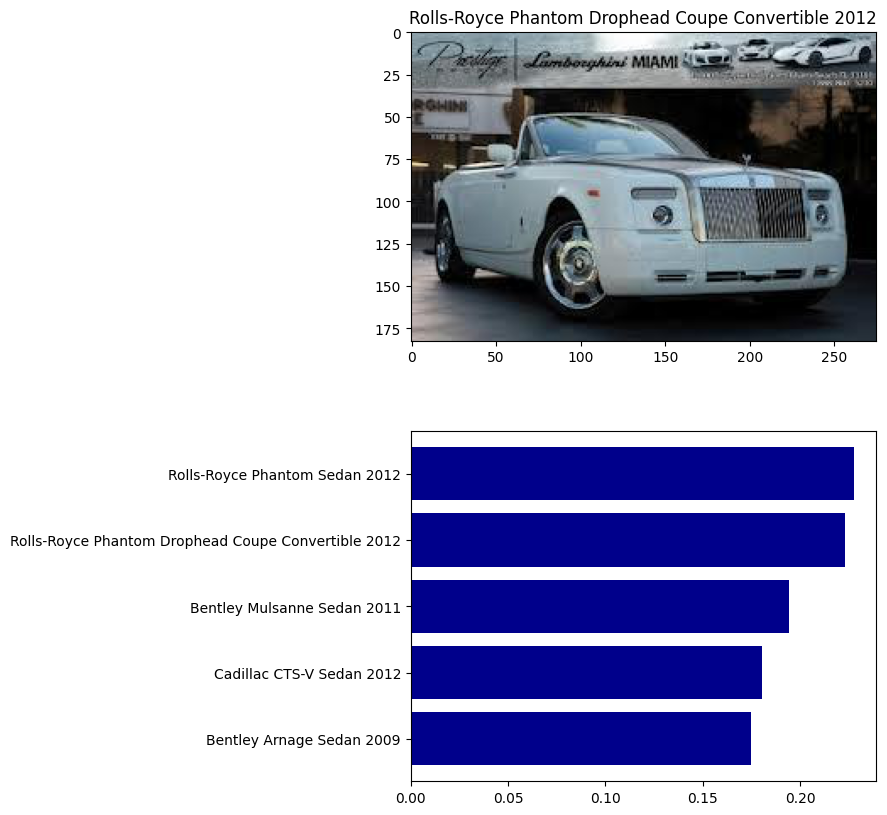

In [ ]:
cardir='/Rolls-Royce Phantom Drophead Coupe Convertible 2012/01154'
plot_solution(cardir , model)

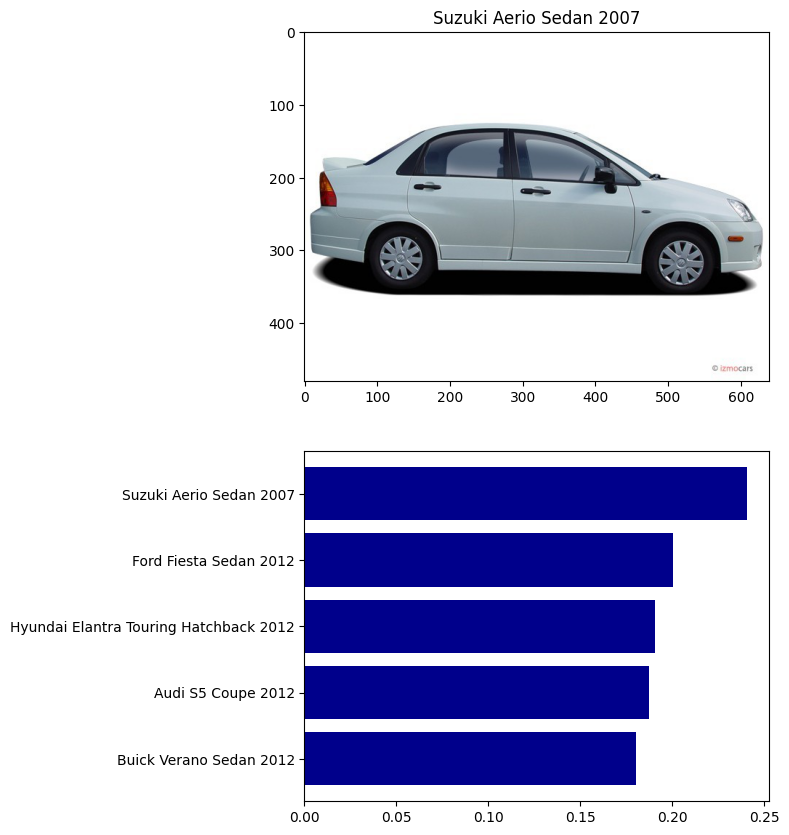

In [ ]:
cardir='/Suzuki Aerio Sedan 2007/00540'
plot_solution(cardir , model)